# **Predictive Quality Control: Identifying High-Impact Manufacturing Events**

## **Problem:**
Our company experiences numerous material defects from various suppliers, leading to costly production downtime. While we log every defect, it's difficult to distinguish between routine issues and critical events that halt operations. We need a data-driven system to predict these high-impact events, allowing us to prioritize our response and better manage supplier risk.

\


**Analytical Approach & Classification Task:**\
To solve this, we will build a machine learning classification model. The model will be trained on historical defect data to predict the severity of a new event, classified as either:

- **High Impact (1):** An event causing downtime in the top 25th percentile of all incidents.
- **Not High Impact (0):** All other events.

\

A key part of our analysis involved a novel feature engineering strategy for our 318 unique suppliers. Instead of treating each vendor individually, we developed a Vendor Priority Ranking. The 20 most frequent suppliers were assigned a unique rank from 1 to 20, while all other less frequent suppliers were grouped into a single 'Other' category (rank 21). This allows the model to learn specific patterns for our key partners while treating the "long tail" of smaller suppliers as a single entity.

\

**Business Value:**

- **Proactive Triage:** The model will serve as an early-warning system. By predicting the likelihood of a defect being High Impact, it will enable quality control teams to immediately escalate critical issues, minimizing production delays and associated costs.
- **Data-Driven Vendor Management:** While the model uses a simplified vendor rank for prediction, our initial analysis produced a comprehensive risk profile for all 318 suppliers. This ranking, based on their historical "High Impact Rate," is an immediately actionable tool for strategic sourcing, contract negotiations, and identifying which specific vendors require targeted quality improvement initiatives.
- **Focused Root Cause Analysis:** By analyzing the model's feature importances, we can identify not just which vendor ranks are problematic, but also which material types and defect categories are the strongest predictors of severe downtime, guiding our engineering and process improvement efforts.

**Why This New Problem Statement is Better**

It's More Precise: It explicitly mentions your unique and intelligent feature engineering step ("Vendor Priority Ranking"), which is a key part of your methodology.
It Separates Analysis from Modeling: It correctly frames the full vendor risk profile (your pivot table) as a valuable analytical output, separate from the simplified rank feature used by the model. This is a very professional distinction to make.
It Manages Expectations: It makes it clear that the model's feature importance will point to a "rank" (e.g., "Rank 5 vendors are risky"), while your separate EDA is what points to a specific vendor name.
It Showcases Your Work: It highlights that you didn't just dump data into a model. You thought critically about how to represent a complex feature, created a custom solution, and can now explain its value.

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting styles for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

In [ ]:
# import warnings
import warnings
warnings.filterwarnings('ignore')

## **Step 1: Data Acquisition**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Economy-Supplier_Quality_Analysis.xlsx to Economy-Supplier_Quality_Analysis.xlsx


In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded['Economy-Supplier_Quality_Analysis.xlsx']))

In [ ]:
# making a dataframe copy
batches = df.copy()

#### Make sure the data is loaded correctly

In [ ]:
# Display the first 5 rows of the DataFrame
batches.head()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes
0,2013-03-18,Browsebug,Westside,IA,Materials & Components,Glass,No Impact,Bad Bearings,929547,3983
1,2014-11-26,Topiczoom,Frazer,MT,Mechanicals,Raw Materials,No Impact,Not Certified,760509,4749
2,2014-10-27,Zoombeat,Jordan Valley,OR,Logistics,Carton,Rejected,Dirty,765963,396
3,2014-04-27,Buzzdog,Barling,AR,Mechanicals,Controllers,No Impact,Warped,31166,124
4,2014-07-06,Meemm,Charles City,VA,Logistics,Molds,No Impact,Other,706546,4038


In [ ]:
# Display the last 5 rows of the DataFrame
batches.tail()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes
5221,2014-09-08,Trudoo,Weaverville,NC,Goods & Services,Raw Materials,No Impact,Not Certified,740273,4191
5222,2013-08-24,Skiba,Chesaning,MI,Mechanicals,Controllers,Rejected,Wrong Tails,393381,3103
5223,2013-10-29,Oyondu,Charles City,VA,Mechanicals,Carton,Impact,Torn Packaging,109205,970
5224,2014-03-21,Kazio,Clarksville,VA,Logistics,Film,Impact,Seams,54650,4522
5225,2014-05-20,Omba,Westside,IA,Logistics,Drives,No Impact,Misc,37689,1513


In [ ]:
batches.columns

Index(['Date', 'Vendor', 'Plant Location', 'State', 'Category',
       'Material Type', 'Defect Type', 'Defect', 'Total Defect Qty',
       'Total Downtime Minutes'],
      dtype='object')

In [ ]:
batches.columns = batches.columns.str.lower().str.replace(' ', '_')

#### Summary of the DataFrame

In [ ]:
batches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5226 non-null   datetime64[ns]
 1   vendor                  5226 non-null   object        
 2   plant_location          5226 non-null   object        
 3   state                   5226 non-null   object        
 4   category                5226 non-null   object        
 5   material_type           5226 non-null   object        
 6   defect_type             5226 non-null   object        
 7   defect                  5226 non-null   object        
 8   total_defect_qty        5226 non-null   int64         
 9   total_downtime_minutes  5226 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 408.4+ KB


- Date (datetime64[ns]): Timestamp of each batch.
- Vendor, Plant Location, State, Category, Material Type, Defect Type, Defect are of object datatype.
- Total Defect Qty, Total Downtime Minutes (int64) are of int64 datatype

In [ ]:
batches.describe(include='all').round(2)

,date,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes
count,5226,5226,5226,5226,5226,5226,5226,5226,5226.00,5226.00
unique,NaN,318,30,21,6,22,3,268,NaN,NaN
top,NaN,Avamm,Riverside,MI,Mechanicals,Raw Materials,No Impact,Not Certified,NaN,NaN
freq,NaN,29,199,929,1638,1573,2083,318,NaN,NaN
mean,2014-01-25 04:03:34.925373184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,497251.14,2477.73
min,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215.00,0.00
25%,2013-08-05 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247887.25,1239.25
50%,2014-02-09 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,495020.50,2472.50
75%,2014-08-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,749285.75,3714.00
max,2014-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,999759.00,5000.00


- Total Batches Analyzed: 5,226 production batches.

- Vendors & Plants: 318 distinct vendors supplying to 30 plant locations across 21 states—suggesting a broad, multi-site operation.

- Product Categories: Six major categories (e.g. “Mechanicals” makes up ~31 % of entries) and 22 material types, so you’ll need to encode a variety of parts and components.

- Defect Profile:
  - 3 defect types (“No Impact,” “Rejected,” “Impact”), with “No Impact” being the most common (~40 % of records).
  - 268 specific defect reasons—“Not Certified” is the single most frequent defect (318 occurrences).

- Average Defects & Downtime: On average, each batch had about 497 K defect units, causing roughly 2,478 minutes of downtime—equivalent to ~41 hours of lost production per batch.

- Best-Case vs. Worst-Case:
  - Defects ranged from as low as 215 units up to nearly 1 million units.
  - Downtime spanned 0 minutes (no delays) up to 5,000 minutes (~83 hours).

- Variability:
  - Defect counts vary widely (std. dev. ≈ 289 K), indicating some batches are far better or worse than average.
  - Downtime variability (std. dev. ≈ 1,434 minutes) shows periods of both smooth operations and significant stoppages.

**These figures highlight the huge spread in batch quality—key opportunities exist to shift more production toward the “better” end of the spectrum to save time and costs.**

In [ ]:
# checking null values
batches.isnull().sum()

,0
date,0
vendor,0
plant_location,0
state,0
category,0
material_type,0
defect_type,0
defect,0
total_defect_qty,0
total_downtime_minutes,0


- There are no null values.

## **2. Exploratory Data Analysis (EDA)**

### Analysis of the Numerical Variable

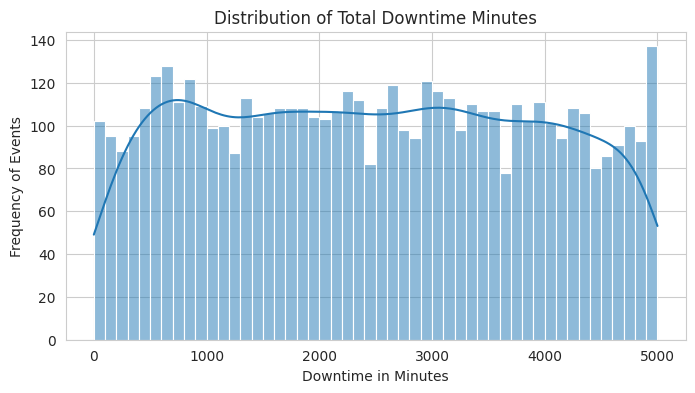

In [ ]:
# Distribution of Total Downtime Minutes

sns.histplot(batches['total_downtime_minutes'], bins=50, kde=True)
plt.title('Distribution of Total Downtime Minutes')
plt.xlabel('Downtime in Minutes')
plt.ylabel('Frequency of Events')
plt.show()

- Wide Range: Downtimes span from minutes to ~5,000 min—so you need both quick‐fix and major incident plans.
- Short Hiccups (500 - 1,000 min): Likely routine resets or maintenance—batch these to cut unplanned stops.
- Mid-Range (1,500 - 3,500 min): Common moderate failures—automate diagnostics and pre-stage spares to shorten repairs.
- Extreme Outliers (~5,000 min): Catastrophic shutdowns—investigate root causes and add redundancies for big savings.

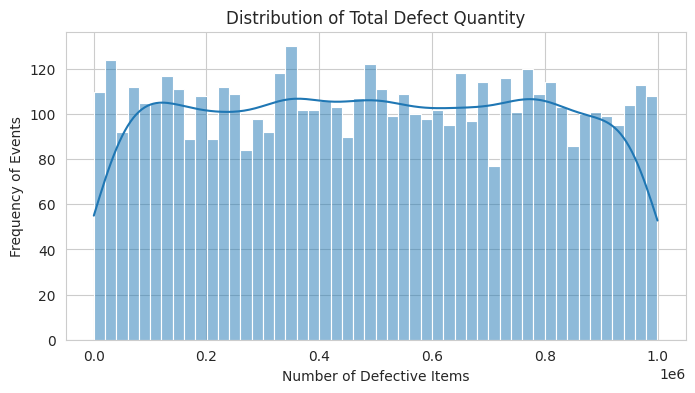

In [ ]:
# Distribution of Total Defect Quantity

sns.histplot(batches['total_defect_qty'], bins=50, kde=True)
plt.title('Distribution of Total Defect Quantity')
plt.xlabel('Number of Defective Items')
plt.ylabel('Frequency of Events')
plt.show()

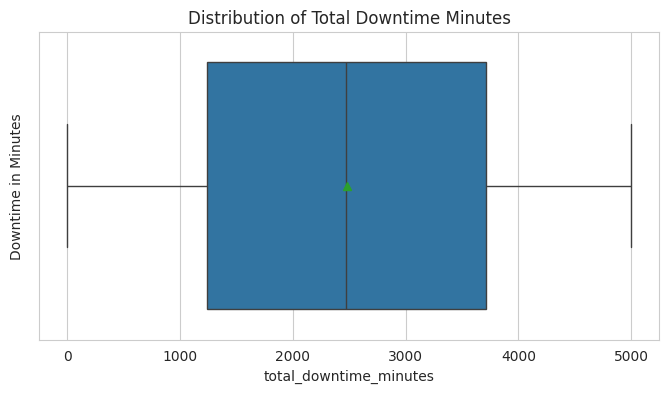

In [ ]:
#boxplot for total_downtime_minutes

sns.boxplot(x='total_downtime_minutes', data=batches, showmeans=True)
plt.title('Distribution of Total Downtime Minutes')
# plt.xlabel('Defect Type')
plt.ylabel('Downtime in Minutes')
plt.show()

In [ ]:
# Combined quantile report for total_downtime_minutes and total_defect_qty
quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.99]

print("Quantile   | total_downtime_minutes | total_defect_qty")
print("-----------|------------------------|------------------")
for q in quantiles:
    q_downtime = batches["total_downtime_minutes"].quantile(q)
    q_defect   = batches["total_defect_qty"].quantile(q)
    print(f"{q:<10.2f} | {q_downtime:>22.2f} | {q_defect:>16.2f}")

Quantile   | total_downtime_minutes | total_defect_qty
-----------|------------------------|------------------
0.01       |                  50.25 |          9575.75
0.05       |                 268.00 |         46750.50
0.25       |                1239.25 |        247887.25
0.50       |                2472.50 |        495020.50
0.75       |                3714.00 |        749285.75
0.99       |                4955.00 |        989942.50


In [ ]:
batches['vendor'].value_counts().nlargest(10).index

Index(['Avamm', 'Izio', 'Roombo', 'Babbleset', 'Edgeblab', 'Feedfire', 'Meetz',
       'Bluezoom', 'Gigazoom', 'Oyope'],
      dtype='object', name='vendor')

### Analysis of Categorical Features

In [ ]:
# Business Question: Who are our most frequent vendors? What are our most common defects? Which plants report the most issues?

def plot_top_n(dataframe, column_name, n=15):
    """Function to plot the top N most frequent categories in a column."""
    top_n = dataframe[column_name].value_counts().nlargest(n)

    ax = sns.barplot(y=top_n.index, x=top_n.values, palette='viridis')

    # Add text labels to each bar
    for i, (value, name) in enumerate(zip(top_n.values, top_n.index)):
        ax.text(value, i, f'{value:,}', va='center', ha='left', fontsize=9)

    plt.title(f'Top {n} Most Frequent Categories for: {column_name.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Number of Events', fontsize=12)
    plt.ylabel(column_name.replace("_", " ").title(), fontsize=12)
    plt.tight_layout()
    plt.show()

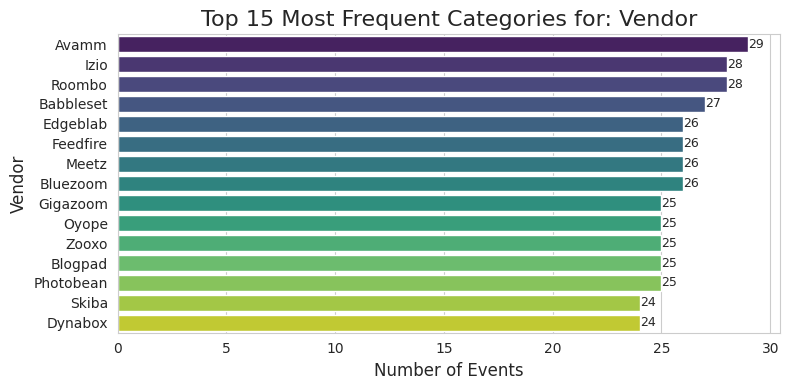

In [ ]:
# 1. Top 15 Vendors by number of defect events
plot_top_n(batches, 'vendor', n=15)

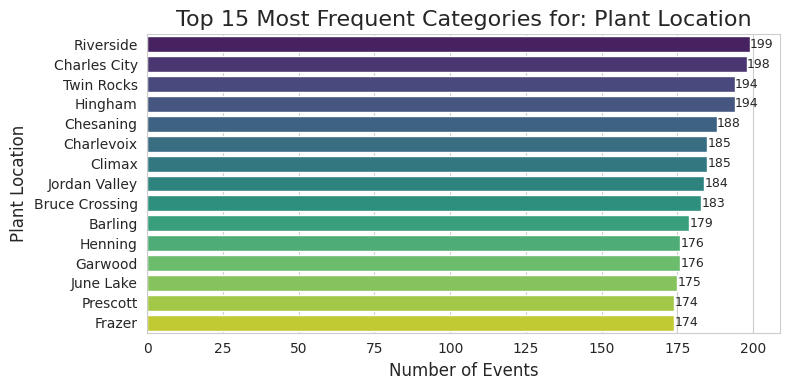

In [ ]:
# 2. Top 15 Plant Locations by number of defect events
plot_top_n(batches, 'plant_location', n=15)

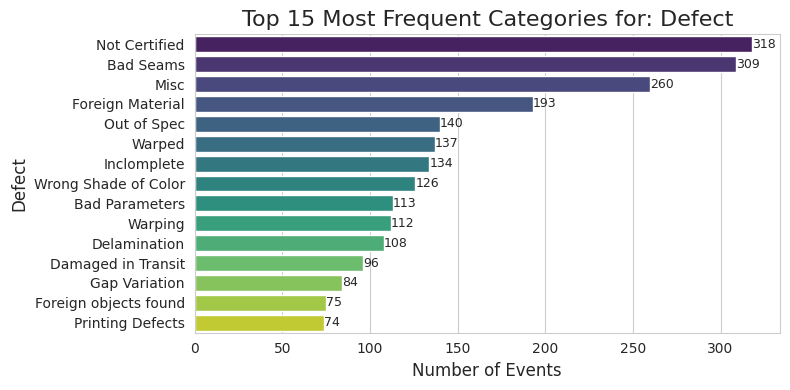

In [ ]:
# 3. Top 15 specific Defects by number of events
plot_top_n(batches, 'defect', n=15)

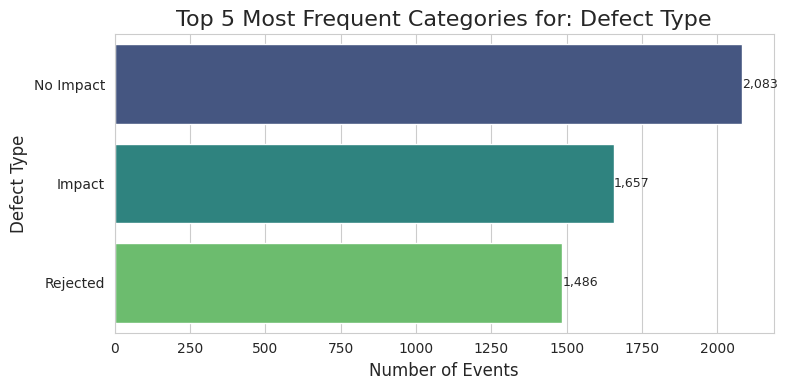

In [ ]:
# 4. Distribution of Defect Type
plot_top_n(batches, 'defect_type', n=5)

In [ ]:
quan_threshold = batches['total_downtime_minutes'].quantile(0.75) # 75th percentile
quan_threshold

np.float64(3714.0)

In [ ]:
batches['is_high_impact'] = (batches['total_downtime_minutes'] >= quan_threshold).astype(int)

In [ ]:
batches['is_high_impact'].value_counts()

,count
is_high_impact,
0,3918
1,1308


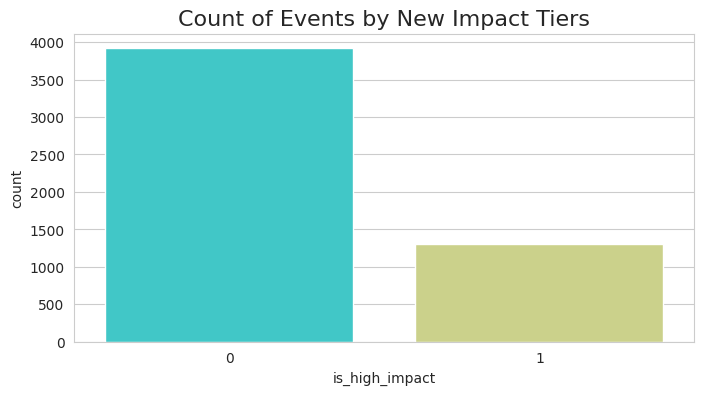

In [ ]:
# Visualize the new classes
sns.countplot(x='is_high_impact', data=batches, order=[0, 1], palette='rainbow')
plt.title('Count of Events by New Impact Tiers', fontsize=16)
plt.show()

In [ ]:
print("\n--- Distribution of the New Tier-Based 'is_high_impact' Column ---")
print(batches['is_high_impact'].value_counts(normalize=True) * 100)


--- Distribution of the New Tier-Based 'is_high_impact' Column ---
is_high_impact
0    74.971297
1    25.028703
Name: proportion, dtype: float64


In [ ]:
batches.head()

,date,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes,is_high_impact
0,2013-03-18,Browsebug,Westside,IA,Materials & Components,Glass,No Impact,Bad Bearings,929547,3983,1
1,2014-11-26,Topiczoom,Frazer,MT,Mechanicals,Raw Materials,No Impact,Not Certified,760509,4749,1
2,2014-10-27,Zoombeat,Jordan Valley,OR,Logistics,Carton,Rejected,Dirty,765963,396,0
3,2014-04-27,Buzzdog,Barling,AR,Mechanicals,Controllers,No Impact,Warped,31166,124,0
4,2014-07-06,Meemm,Charles City,VA,Logistics,Molds,No Impact,Other,706546,4038,1


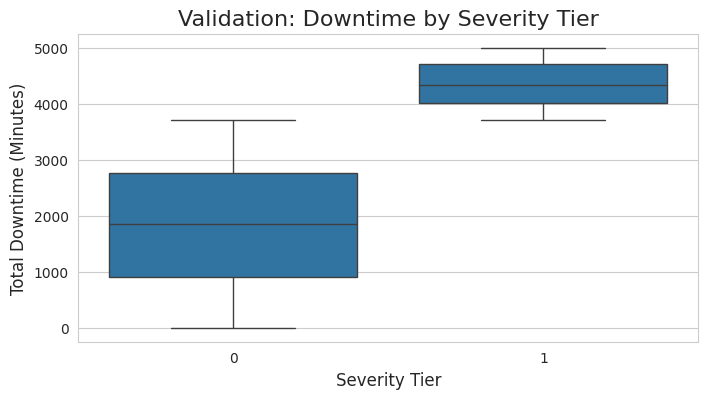

In [ ]:
# This is a sanity check to make sure our tiers were created correctly.

sns.boxplot(x='is_high_impact', y='total_downtime_minutes', data=batches, order=[0,1])
plt.title('Validation: Downtime by Severity Tier', fontsize=16)
plt.xlabel('Severity Tier', fontsize=12)
plt.ylabel('Total Downtime (Minutes)', fontsize=12)
plt.show()

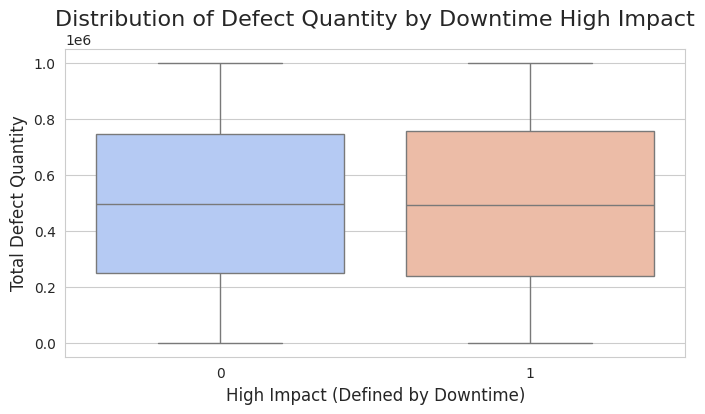

In [ ]:
# This is the important plot. It tells us if downtime severity is related to quantity severity.

sns.boxplot(x='is_high_impact', y='total_defect_qty', data=batches, order=[0,1], palette='coolwarm')
plt.title('Distribution of Defect Quantity by Downtime High Impact', fontsize=16)
plt.xlabel('High Impact (Defined by Downtime)', fontsize=12)
plt.ylabel('Total Defect Quantity', fontsize=12)
plt.show()

In [ ]:
batches['total_defect_qty'].where(batches['is_high_impact'] == 1).describe()

,total_defect_qty
count,1308.000000
mean,492840.546636
std,295200.445114
min,718.000000
25%,240010.500000
50%,490555.000000
75%,755102.000000
max,999023.000000


In [ ]:
batches['total_defect_qty'].where(batches['is_high_impact'] == 0).describe()

,total_defect_qty
count,3918.000000
mean,498723.590863
std,287387.143604
min,215.000000
25%,249741.000000
50%,496015.000000
75%,746854.250000
max,999759.000000


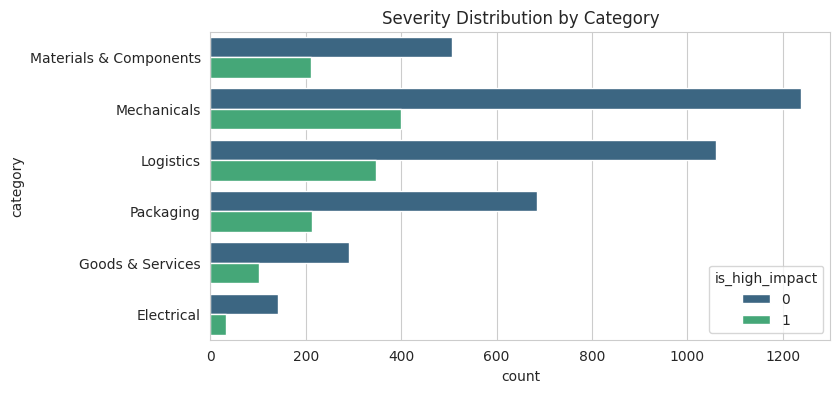

In [ ]:
# Category vs Severity countplot

sns.countplot(y='category', hue='is_high_impact', data=batches, palette='viridis')
plt.title('Severity Distribution by Category')
plt.show()

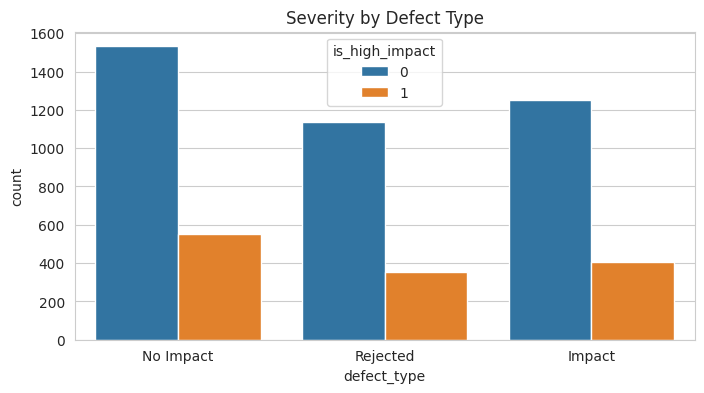

In [ ]:
# Defect Type vs Severity

sns.countplot(data=batches, x='defect_type', hue='is_high_impact')
plt.title('Severity by Defect Type')
plt.show()

## **3. Data Cleaning**

In [ ]:
batches = batches.drop(columns='date')

In [ ]:
batches.columns

Index(['vendor', 'plant_location', 'state', 'category', 'material_type',
       'defect_type', 'defect', 'total_defect_qty', 'total_downtime_minutes',
       'is_high_impact'],
      dtype='object')

In [ ]:
#converting object to category datatype
batches['vendor'] = batches['vendor'].astype('category')
batches['plant_location'] = batches['plant_location'].astype('category')
batches['state'] = batches['state'].astype('category')
batches['category'] = batches['category'].astype('category')
batches['material_type'] = batches['material_type'].astype('category')
batches['defect_type'] = batches['defect_type'].astype('category')
batches['defect'] = batches['defect'].astype('category')

In [ ]:
batches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   vendor                  5226 non-null   category
 1   plant_location          5226 non-null   category
 2   state                   5226 non-null   category
 3   category                5226 non-null   category
 4   material_type           5226 non-null   category
 5   defect_type             5226 non-null   category
 6   defect                  5226 non-null   category
 7   total_defect_qty        5226 non-null   int64   
 8   total_downtime_minutes  5226 non-null   int64   
 9   is_high_impact          5226 non-null   int64   
dtypes: category(7), int64(3)
memory usage: 192.4 KB


likely to see if vendor names have shared prefixes or if there is typo error

In [ ]:
batches['vendor'] = batches['vendor'].str.strip().str.lower().str.replace('  ', ' ', regex=False)
batches['plant_location'] = batches['plant_location'].str.strip().str.lower().str.replace('  ', ' ', regex=False)
batches['category'] = batches['category'].str.strip().str.lower().str.replace('  ', ' ', regex=False)
batches['material_type'] = batches['material_type'].str.strip().str.lower().str.replace('  ', ' ', regex=False)
batches['defect_type'] = batches['defect_type'].str.strip().str.lower().str.replace('  ', ' ', regex=False)

In [ ]:
#vendor
print(list(batches['vendor'].value_counts().index.sort_values()))

['abata', 'abatz', 'agimba', 'agivu', 'aibox', 'ailane', 'aimbu', 'ainyx', 'aivee', 'avamba', 'avamm', 'avavee', 'babbleblab', 'babbleopia', 'babbleset', 'babblestorm', 'blognation', 'blogpad', 'blogspan', 'blogtag', 'blogtags', 'bluejam', 'bluezoom', 'brainbox', 'brainlounge', 'brainsphere', 'brainverse', 'brightbean', 'brightdog', 'browseblab', 'browsebug', 'browsecat', 'browsedrive', 'browsetype', 'browsezoom', 'bubblebox', 'bubblemix', 'bubbletube', 'buzzdog', 'buzzshare', 'buzzster', 'camido', 'camimbo', 'centidel', 'centimia', 'centizu', 'chatterbridge', 'chatterpoint', 'cogibox', 'cogilith', 'dabfeed', 'dabjam', 'dablist', 'dabshots', 'dabtype', 'dabvine', 'dabz', 'dazzlesphere', 'demimbu', 'demivee', 'devbug', 'devify', 'devpoint', 'devpulse', 'devshare', 'digitube', 'divape', 'divavu', 'dynabox', 'dynava', 'eabox', 'eamia', 'eare', 'eayo', 'eazzy', 'edgeblab', 'edgeify', 'edgepulse', 'eidel', 'eimbee', 'einti', 'eire', 'fadeo', 'fanoodle', 'fatz', 'feedbug', 'feedfire', 'feedf

In [ ]:
batches[batches['vendor'].str.contains(' ')]

,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes,is_high_impact


In [ ]:
# observing data for Ava
batches[(batches['vendor'] == 'avamba') | (batches['vendor'] == 'avamm') | (batches['vendor'] == 'avavee')].sort_values(by='state')

,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes,is_high_impact
3774,avamm,cottonwood,AZ,mechanicals,carton,impact,Torn Packaging,128746,3030,0
3348,avavee,cottonwood,AZ,electrical,labels,rejected,Loose Core,997788,3080,0
4494,avavee,june lake,CA,logistics,controllers,rejected,Misc,856095,3034,0
4816,avamm,new britain,CT,logistics,corrugate,impact,Gap Variation,409093,69,0
504,avamm,new britain,CT,electrical,carton,rejected,Wrong Fasteners,739649,1510,0
4086,avamba,new britain,CT,packaging,corrugate,impact,Skewed,593409,357,0
434,avavee,westside,IA,logistics,corrugate,rejected,Delamination,914783,4900,1
5192,avamm,henning,IL,mechanicals,carton,rejected,Printing Defects,522795,971,0
3017,avamm,florence,KY,packaging,film,no impact,Wrong Shade of Color,454348,1900,0
3174,avamm,hingham,MA,mechanicals,raw materials,no impact,Not Certified,912606,3778,1


Vendor's name are correct and not basically related on prefix.

In [ ]:
# plant_location
batches['plant_location'].value_counts()

,count
plant_location,
riverside,199
charles city,198
twin rocks,194
hingham,194
chesaning,188
charlevoix,185
climax,185
jordan valley,184
bruce crossing,183


In [ ]:
batches[batches['plant_location'].str.contains(' ')]['plant_location'].unique()

array(['jordan valley', 'charles city', 'de ruyter', 'new britain',
       'twin rocks', 'june lake', 'bruce crossing'], dtype=object)

In [ ]:
# state
batches['state'].value_counts()

,count
state,
MI,929
NY,656
VA,360
PA,354
MA,194
MN,185
OR,184
AR,179
IL,176


In [ ]:
# category
batches['category'].value_counts()

,count
category,
mechanicals,1638
logistics,1407
packaging,898
materials & components,717
goods & services,392
electrical,174


In [ ]:
batches['material_type'].describe()

NameError: name 'batches' is not defined

In [ ]:
# material_type
batches['material_type'].value_counts()

,count
material_type,
raw materials,1573
corrugate,1265
film,406
labels,362
carton,356
controllers,274
batteries,223
glass,167
electrolytes,162


In [ ]:
# defect_type
batches['defect_type'].value_counts()

,count
defect_type,
no impact,2083
impact,1657
rejected,1486


In [ ]:
# defect
print(list(batches['defect'].value_counts().index.sort_values()))

['Assembly Issues', 'Bad Bearings', 'Bad Bond', 'Bad Carton Packaging', 'Bad Cut', 'Bad Distribution', 'Bad Fasteners', 'Bad Fill', 'Bad Film', 'Bad Finish', 'Bad Fit', 'Bad Flaps', 'Bad Insert', 'Bad Labels', 'Bad Parameters', 'Bad Print', 'Bad Seal', 'Bad Seams', 'Bad Shots', 'Bad Tiles', 'Bad Tops', 'Bad Valves', 'Bad Welding', 'Blisters', 'Bowed', 'Bowed/Warped', 'Broken Glass', 'Broken Valve Seal', 'Bubbling', 'Bulging Packaging', 'Burnt', 'Carton Delamination', 'Cartons Not Opening', 'Coating', 'Codes Wrong', 'Color Deviation', 'Color Variation', 'Component Failure', 'Components Stuck', 'Container Out of Spec', 'Contamination', 'Corrugate Falling Apart', 'Crack', 'Cracked', 'Creases / Wrinkles', 'Crooked', 'Crushed Sidewalls', 'Cut Box', 'Cut Wires', 'Cuts', 'Damaged', 'Damaged Components', 'Damaged Parts', 'Damaged Rolls', 'Damaged Secondary Packaging', 'Damaged in Transit', 'Deep Slots', 'Defective Packaging', 'Defective Rims', 'Deformed Parts', 'Delamination', 'Dents', 'Dimens

In [ ]:
batches['defect'] = batches['defect'].str.strip().str.lower().str.replace('/','',regex=False).str.replace('  ', ' ', regex=False)

- defect column is rich with information but also "messy."
- The model will struggle to find patterns if it treats "Wrong Size" and "Wrong Size" (with an extra space) or "Printing Defects" and "Print defects" as completely separate issues.

In [ ]:
batches['defect'].nunique()

267

In [ ]:
batchesEmbd = pd.DataFrame(batches)

In [ ]:
batchesEmbd.head()

,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes,is_high_impact
0,browsebug,westside,IA,materials & components,glass,no impact,bad bearings,929547,3983,1
1,topiczoom,frazer,MT,mechanicals,raw materials,no impact,not certified,760509,4749,1
2,zoombeat,jordan valley,OR,logistics,carton,rejected,dirty,765963,396,0
3,buzzdog,barling,AR,mechanicals,controllers,no impact,warped,31166,124,0
4,meemm,charles city,VA,logistics,molds,no impact,other,706546,4038,1




---


### **Text Embedding - for Defect column**

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [ ]:
# Step 1: Prepare the unique defect text data
unique_defects = batches['defect'].unique().tolist()
print(f"Found {len(unique_defects)} unique defect descriptions to process.")

Found 267 unique defect descriptions to process.


In [ ]:
# Step 2: Generate Text Embeddings
# We use a pre-trained model. 'all-MiniLM-L6-v2' is a great, lightweight choice

print("Loading sentence transformer model and generating embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
defect_embeddings = model.encode(unique_defects, show_progress_bar=True)
print("Embeddings created. Shape:", defect_embeddings.shape)

Loading sentence transformer model and generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Embeddings created. Shape: (267, 384)


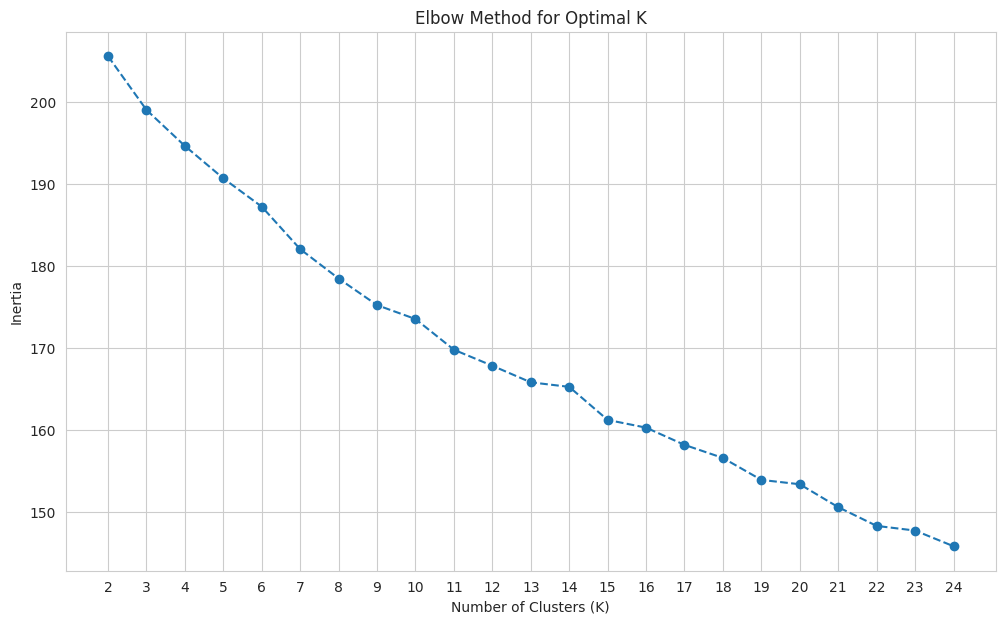

In [ ]:
# Step 3: Find the Optimal Number of Clusters (K) using the Elbow Method
# We test different numbers of clusters and see where the "inertia" (a measure of cluster cohesion) flattens out

inertia = []
k_range = range(2, 25) # Let's test from 2 to 24 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Set n_init to suppress a future warning
    kmeans.fit(defect_embeddings)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 7))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
!pip install -q KeyBERT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.1 MB/s eta 0:00:00


In [ ]:
from keybert import KeyBERT

# --- Step 1: Run K-Means with Your Chosen K=7 ---
OPTIMAL_K = 6
print(f"Running K-Means with the chosen optimal K = {OPTIMAL_K}")

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans.fit(defect_embeddings)

Running K-Means with the chosen optimal K = 6


KMeans(n_clusters=6, n_init=10, random_state=42)

In [ ]:
# Create a mapping from each unique defect description to its cluster ID (0-6)
defect_to_cluster_map = dict(zip(unique_defects, kmeans.labels_))
print("Clustering complete.")


#Step 2: Automatically Generate Cluster Names with KeyBERT
print("\nAutomatically Generating Cluster Names with KeyBERT.....")

# Initialize the KeyBERT model
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

# This dictionary will store our final names, e.g., {0: 'seam_and_seal_issue', 1: 'print_quality_defect', ...}
auto_cluster_names = {}

for i in range(OPTIMAL_K):
    # a. Get all defect descriptions for the current cluster
    cluster_defects = [defect for defect, cluster_id in defect_to_cluster_map.items() if cluster_id == i]

    # b. Join them into a single block of text to be summarized
    document = ". ".join(cluster_defects)

    # c. Extract the best descriptive phrase (1 to 3 words long)
    keywords = kw_model.extract_keywords(document,
                                         keyphrase_ngram_range=(1, 2),
                                         stop_words='english',
                                         top_n=1)

    # d. Get the generated name and clean it up for use as a column name
    if keywords:
        # Replace spaces with underscores and make it lowercase
        cluster_name = keywords[0][0].replace(' ', '_')
    else:
        cluster_name = f"cluster_{i}_unnamed" # Fallback name

    auto_cluster_names[i] = cluster_name

    print(f"Cluster {i}: Suggested Name = '{cluster_name}'")

Clustering complete.

Automatically Generating Cluster Names with KeyBERT.....
Cluster 0: Suggested Name = 'certified_misc'
Cluster 1: Suggested Name = 'warped_folding'
Cluster 2: Suggested Name = 'printing_defects'
Cluster 3: Suggested Name = 'damaged_components'
Cluster 4: Suggested Name = 'wrong_ink'
Cluster 5: Suggested Name = 'spacing_labels'


In [ ]:
#Step 3: Create the Final DataFrame Column
print("\n--- Applying the new names to the DataFrame ---")

# a. First, create the column with the numerical cluster IDs
batchesEmbd['defect_cluster_id'] = batchesEmbd['defect'].map(defect_to_cluster_map)

# b. Now, map these IDs to your newly generated names to create the final, human-readable column
batchesEmbd['defect_category_auto'] = batchesEmbd['defect_cluster_id'].map(auto_cluster_names)

# c. Clean up by dropping the intermediate columns
# You can keep 'defect_cluster_id' for now if you want to inspect it, or drop it.
# Let's drop the original 'defect' column as it has now been replaced.
batchesEmbd_F = batchesEmbd.drop(columns=['defect_cluster_id'])


--- Applying the new names to the DataFrame ---


In [ ]:
batchesEmbd_F.head()

,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes,is_high_impact,defect_category_auto
0,browsebug,westside,IA,materials & components,glass,no impact,bad bearings,929547,3983,1,damaged_components
1,topiczoom,frazer,MT,mechanicals,raw materials,no impact,not certified,760509,4749,1,certified_misc
2,zoombeat,jordan valley,OR,logistics,carton,rejected,dirty,765963,396,0,damaged_components
3,buzzdog,barling,AR,mechanicals,controllers,no impact,warped,31166,124,0,warped_folding
4,meemm,charles city,VA,logistics,molds,no impact,other,706546,4038,1,certified_misc


In [ ]:
batchesEmbd_F['defect_category_auto'].value_counts()

,count
defect_category_auto,
certified_misc,1415
warped_folding,1205
damaged_components,1060
wrong_ink,906
printing_defects,490
spacing_labels,150


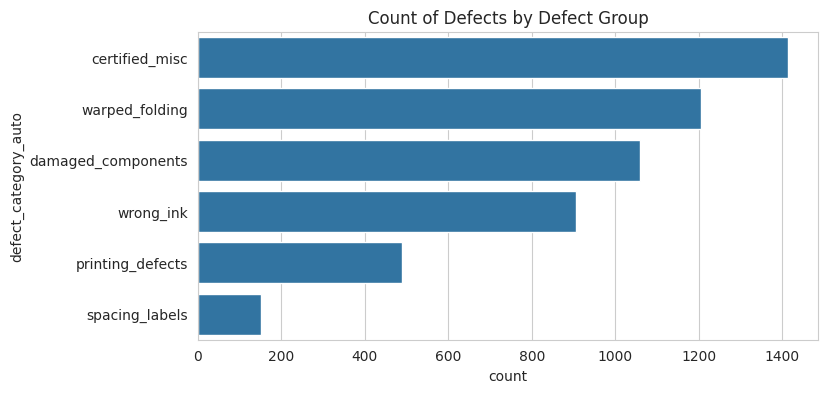

In [ ]:
# plot for defect_group
sns.countplot(data=batchesEmbd_F, y='defect_category_auto',order=batchesEmbd_F['defect_category_auto'].value_counts().index)
plt.title('Count of Defects by Defect Group')
# plt.xticks(rotation=45)
plt.show()

**Now about Vendor's**

In [ ]:
nlargest_Variable = 20
top_n_vendors = batchesEmbd_F['vendor'].value_counts().nlargest(nlargest_Variable).index.tolist()
top_n_vendors

['avamm',
 'izio',
 'roombo',
 'babbleset',
 'edgeblab',
 'feedfire',
 'meetz',
 'bluezoom',
 'gigazoom',
 'oyope',
 'zooxo',
 'blogpad',
 'photobean',
 'skiba',
 'dynabox',
 'reallinks',
 'bubblemix',
 'talane',
 'layo',
 'brightbean']

In [ ]:
vendor_to_rank_map = {}
# Loop through the top 10 vendors and assign ranks 1 through 10
for i, vendor in enumerate(top_n_vendors):
    vendor_to_rank_map[vendor] = i + 1

vendor_to_rank_map

{'avamm': 1,
 'izio': 2,
 'roombo': 3,
 'babbleset': 4,
 'edgeblab': 5,
 'feedfire': 6,
 'meetz': 7,
 'bluezoom': 8,
 'gigazoom': 9,
 'oyope': 10,
 'zooxo': 11,
 'blogpad': 12,
 'photobean': 13,
 'skiba': 14,
 'dynabox': 15,
 'reallinks': 16,
 'bubblemix': 17,
 'talane': 18,
 'layo': 19,
 'brightbean': 20}

In [ ]:
def assign_n_rank(vendor):
  return vendor_to_rank_map.get(vendor, nlargest_Variable+1)

In [ ]:
batchesEmbd_F['vendor_rank_topn'] = batchesEmbd_F['vendor'].apply(assign_n_rank)
batchesEmbd_F.head()

,vendor,plant_location,state,category,material_type,defect_type,defect,total_defect_qty,total_downtime_minutes,is_high_impact,defect_category_auto,vendor_rank_topn
0,browsebug,westside,IA,materials & components,glass,no impact,bad bearings,929547,3983,1,damaged_components,21
1,topiczoom,frazer,MT,mechanicals,raw materials,no impact,not certified,760509,4749,1,certified_misc,21
2,zoombeat,jordan valley,OR,logistics,carton,rejected,dirty,765963,396,0,damaged_components,21
3,buzzdog,barling,AR,mechanicals,controllers,no impact,warped,31166,124,0,warped_folding,21
4,meemm,charles city,VA,logistics,molds,no impact,other,706546,4038,1,certified_misc,21


In [ ]:
batchesEmbd_F['vendor_rank_topn'].value_counts()

,count
vendor_rank_topn,
21,4721
1,29
3,28
2,28
4,27
6,26
8,26
5,26
7,26


After this differentiating in vendor column, lets check on WOE for both model. then start building model

Random forest
adaboost
xgboost
lightgbm

In [ ]:
batchesEmbd_Final = pd.DataFrame(batchesEmbd_F)

In [ ]:
batchesEmbd_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   vendor                  5226 non-null   object  
 1   plant_location          5226 non-null   object  
 2   state                   5226 non-null   category
 3   category                5226 non-null   object  
 4   material_type           5226 non-null   object  
 5   defect_type             5226 non-null   object  
 6   defect                  5226 non-null   object  
 7   total_defect_qty        5226 non-null   int64   
 8   total_downtime_minutes  5226 non-null   int64   
 9   is_high_impact          5226 non-null   int64   
 10  defect_category_auto    5226 non-null   object  
 11  vendor_rank_topn        5226 non-null   int64   
dtypes: category(1), int64(4), object(7)
memory usage: 455.0+ KB


In [ ]:
# changing both dataframes datatypes object to category
batchesEmbd_Final['plant_location'] = batchesEmbd_Final['plant_location'].astype('category')
batchesEmbd_Final['state'] = batchesEmbd_Final['state'].astype('category')
batchesEmbd_Final['category'] = batchesEmbd_Final['category'].astype('category')
batchesEmbd_Final['material_type'] = batchesEmbd_Final['material_type'].astype('category')
batchesEmbd_Final['defect_type'] = batchesEmbd_Final['defect_type'].astype('category')
batchesEmbd_Final['defect_category_auto'] = batchesEmbd_Final['defect_category_auto'].astype('category')

In [ ]:
batchesEmbd_Final = batchesEmbd_Final.drop(['vendor','defect','total_downtime_minutes'],axis=1)

In [ ]:
batchesEmbd_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   plant_location        5226 non-null   category
 1   state                 5226 non-null   category
 2   category              5226 non-null   category
 3   material_type         5226 non-null   category
 4   defect_type           5226 non-null   category
 5   total_defect_qty      5226 non-null   int64   
 6   is_high_impact        5226 non-null   int64   
 7   defect_category_auto  5226 non-null   category
 8   vendor_rank_topn      5226 non-null   int64   
dtypes: category(6), int64(3)
memory usage: 156.5 KB


In [ ]:
batchesEmbd_Final.columns

Index(['plant_location', 'state', 'category', 'material_type', 'defect_type',
       'total_defect_qty', 'is_high_impact', 'defect_category_auto',
       'vendor_rank_topn'],
      dtype='object')

In [ ]:
features_to_analyze_1 = ['plant_location', 'state', 'category', 'material_type', 'defect_type', 'defect_category_auto']
target_name = 'is_high_impact'



---



# use Chi square test once for correlation between variables

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
features_to_analyze_1

['plant_location',
 'state',
 'category',
 'material_type',
 'defect_type',
 'defect_category_auto']

In [ ]:
chi2_results = []

for feature in features_to_analyze_1:
    contingency_table = pd.crosstab(batchesEmbd_Final[feature], batchesEmbd_Final['is_high_impact'])

    # 2. Perform the Chi-Squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # 3. Store the results in our list
    result = {
        "Feature": feature,
        "P-value": p_value,
        "Chi-Squared Statistic": chi2
    }
    chi2_results.append(result)

In [ ]:
results_df = pd.DataFrame(chi2_results)

results_df['Association with Target'] = np.where(results_df['P-value'] < 0.05, 'Significant', 'Not Significant')

# Sort by p-value to see the most significant features first
results_df = results_df.sort_values(by='P-value', ascending=True)

results_df

,Feature,P-value,Chi-Squared Statistic,Association with Target
3,material_type,0.001077,46.557338,Significant
2,category,0.033631,12.085776,Significant
5,defect_category_auto,0.056882,10.735592,Not Significant
4,defect_type,0.136851,3.977731,Not Significant
1,state,0.622447,17.467416,Not Significant
0,plant_location,0.748077,23.606688,Not Significant


**Information Value (IV)**: Measures the magnitude of the separation power. It can sometimes be "fooled" by random noise in a large dataset, leading it to report a small, weak value that isn't statistically meaningful. \
**Chi-Squared Test of Independence**: Directly tests the statistical significance of an association. Its entire purpose is to tell you whether a perceived relationship is real or just random chance.

In [ ]:
# --- Final Recommendation based on the test ---
print("\n--- Feature Selection Recommendation ---")
significant_features = results_df[results_df['Association with Target'] == 'Significant']['Feature'].tolist()
print("Features with a significant association (p < 0.05) that should be kept:")
print(significant_features)

insignificant_features = results_df[results_df['Association with Target'] == 'Not Significant']['Feature'].tolist()
print("\nFeatures with no significant association that could be dropped:")
insignificant_features


--- Feature Selection Recommendation ---
Features with a significant association (p < 0.05) that should be kept:
['material_type', 'category']

Features with no significant association that could be dropped:


['defect_category_auto', 'defect_type', 'state', 'plant_location']

### **Creating Final Dataframe from all this tests**

In [ ]:
batchesEmbd_Final.columns

Index(['plant_location', 'state', 'category', 'material_type', 'defect_type',
       'total_defect_qty', 'is_high_impact', 'defect_category_auto',
       'vendor_rank_topn'],
      dtype='object')

In [ ]:
# creating the final dataframe
final_batches_df = batchesEmbd_Final.drop(columns=['state','plant_location','defect_type','defect_category_auto'])
# final_batches_df = batches_model_DF2.copy()
final_batches_df.head()

,category,material_type,total_defect_qty,is_high_impact,vendor_rank_topn
0,materials & components,glass,929547,1,21
1,mechanicals,raw materials,760509,1,21
2,logistics,carton,765963,0,21
3,mechanicals,controllers,31166,0,21
4,logistics,molds,706546,1,21


In [ ]:
X = final_batches_df.drop(columns=['is_high_impact'],axis=1)
y = final_batches_df['is_high_impact']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226 entries, 0 to 5225
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   category          5226 non-null   category
 1   material_type     5226 non-null   category
 2   total_defect_qty  5226 non-null   int64   
 3   vendor_rank_topn  5226 non-null   int64   
dtypes: category(2), int64(2)
memory usage: 92.9 KB


In [ ]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5226 entries, 0 to 5225
Series name: is_high_impact
Non-Null Count  Dtype
--------------  -----
5226 non-null   int64
dtypes: int64(1)
memory usage: 41.0 KB


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
categorical_features = ['vendor_rank_topn', 'material_type', 'category']
# categorical_features = ['vendor_risk_group', 'plant_location', 'state', 'category','material_type', 'defect_type', 'defect_category_auto']
numerical_features = ['total_defect_qty']

In [ ]:
# --- Step 2: Create the Preprocessing Pipeline ---
# This preprocessor will be used by all models to ensure consistency.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [ ]:
# Calculate the weight for handling imbalance in XGBoost
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier()
}

In [ ]:
scoring_metrics = ['accuracy','roc_auc']

all_results = []

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# print("--- Starting Cross-Validation for 4 Models ---")

for model_name, model in models.items():
    # Create a unique pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Perform cross-validation
    cv_scores = cross_validate(
        pipeline, X_train, y_train,
        cv=cv_strategy,
        scoring=scoring_metrics,
        return_train_score=True
    )

    results_summary = {

        'Model': model_name,
        'Train Accuracy': cv_scores['train_accuracy'],
        'Train ROC AUC': cv_scores['train_roc_auc'],

        'Test Accuracy': cv_scores['test_accuracy'],
        'Test Avg ROC AUC': cv_scores['test_roc_auc']
    }

    # Print train and test accuracy for each fold
    print(f'Model: {model_name}')
    for i in range(len(cv_scores['train_accuracy'])):
        print(f"  Fold {i + 1}: Train Accuracy = {cv_scores['train_accuracy'][i]:.4f}, Test Accuracy = {cv_scores['test_accuracy'][i]:.4f}, Train ROC-AUC = {cv_scores['train_roc_auc'][i]:.4f}, Test ROC-AUC = {cv_scores['test_roc_auc'][i]:.4f}")
    print('-' * 50)

    all_results.append(results_summary)

Model: RandomForest
  Fold 1: Train Accuracy = 0.9997, Test Accuracy = 0.6161, Train ROC-AUC = 1.0000, Test ROC-AUC = 0.4575
  Fold 2: Train Accuracy = 0.9993, Test Accuracy = 0.6216, Train ROC-AUC = 1.0000, Test ROC-AUC = 0.4566
  Fold 3: Train Accuracy = 0.9997, Test Accuracy = 0.6079, Train ROC-AUC = 1.0000, Test ROC-AUC = 0.4447
  Fold 4: Train Accuracy = 0.9990, Test Accuracy = 0.6101, Train ROC-AUC = 1.0000, Test ROC-AUC = 0.4600
  Fold 5: Train Accuracy = 1.0000, Test Accuracy = 0.6047, Train ROC-AUC = 1.0000, Test ROC-AUC = 0.4337
--------------------------------------------------
Model: AdaBoost
  Fold 1: Train Accuracy = 0.7485, Test Accuracy = 0.7473, Train ROC-AUC = 0.5413, Test ROC-AUC = 0.4890
  Fold 2: Train Accuracy = 0.7491, Test Accuracy = 0.7486, Train ROC-AUC = 0.5567, Test ROC-AUC = 0.5015
  Fold 3: Train Accuracy = 0.7491, Test Accuracy = 0.7486, Train ROC-AUC = 0.5348, Test ROC-AUC = 0.5334
  Fold 4: Train Accuracy = 0.7482, Test Accuracy = 0.7483, Train ROC-AUC 

Among all the models you've tested, XGBoost offers the best balance between learning and generalization:

- RandomForest has the highest train scores but severely overfits (Train F1: 0.999 vs Test F1: 0.51).
- AdaBoost generalizes well but shows poor overall performance.
- LightGBM is decent, but XGBoost has better regularization and tuning flexibility.
- XGBoost achieves a moderate train F1 (0.66) and competitive test F1 (0.49), with a much smaller overfitting gap than RandomForest and better performance than AdaBoost or LightGBM.

**Conclusion:** XGBoost offers the most promising starting point — strong performance, lower overfitting, and powerful tuning options — making it the best candidate to improve further.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# We fit on the training data and transform both train and test.
categorical_features = ['vendor_rank_topn', 'material_type', 'category']
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit on training data and transform it
X_train_cat = encoder.fit_transform(X_train[categorical_features])
# Transform the test data using the same fitted encoder
X_test_cat = encoder.transform(X_test[categorical_features])

In [ ]:
# Create DataFrames from the sparse matrices and get feature names
X_train_cat_df = pd.DataFrame(X_train_cat.toarray(), index=X_train.index, columns=encoder.get_feature_names_out())
X_test_cat_df = pd.DataFrame(X_test_cat.toarray(), index=X_test.index, columns=encoder.get_feature_names_out())

# Combine with numerical features
X_train_final = pd.concat([X_train[['total_defect_qty']].reset_index(drop=True), X_train_cat_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test[['total_defect_qty']].reset_index(drop=True), X_test_cat_df.reset_index(drop=True)], axis=1)

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'learning_rate': [0.001, 0.005, 0.01, 0.1],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [ ]:
# Calculate the scale_pos_weight for handling imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [ ]:
# Initialize the XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [ ]:
# Define the CV strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  # Try 50 different parameter combinations
    scoring='f1_macro',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2, # Shows progress
    random_state=42
)

In [ ]:
print("\n--- Starting Hyperparameter Tuning with RandomizedSearchCV... ---")
# Fit the random search to your TRAINING data
# This process will automatically perform the 5-fold CV for each of the 50 iterations.
random_search.fit(X_train_final, y_train)


--- Starting Hyperparameter Tuning with RandomizedSearchCV... ---
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.1],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [ ]:
# --- Step 6: View the Best Results ---
print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best Score from Cross-Validation: {random_search.best_score_:.4f}")
print("Best Parameters Found:")
print(random_search.best_params_)


--- Hyperparameter Tuning Complete ---
Best Score from Cross-Validation: 0.4953
Best Parameters Found:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.5}


In [ ]:
# The `random_search.best_estimator_` is now your final, tuned model,
# which has been automatically refit on the entire training set using the best parameters found.
best_model = random_search.best_estimator_

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# 1. Fit best_model on the full training set
best_model.fit(X_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 2. Predict on both train and test
y_train_pred = best_model.predict(X_train_final)
y_test_pred = best_model.predict(X_test_final)

# predict_proba for ROC AUC
y_train_proba = best_model.predict_proba(X_train_final)[:, 1]
y_test_proba = best_model.predict_proba(X_test_final)[:, 1]

In [ ]:
# 3. Define a function to print metrics
def print_metrics(y_true, y_pred, y_proba, dataset_name="Data"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_true, y_proba, multi_class='ovr'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [ ]:
# 4. Print metrics
print_metrics(y_train, y_train_pred, y_train_proba, "Train")
print_metrics(y_test, y_test_pred, y_test_proba, "Test")


--- Train Metrics ---
Accuracy: 0.6842536905412794
Precision: 0.5720240489358136
Recall: 0.568196036380846
F1 Score: 0.5697651625044106
ROC AUC: 0.6190912563864237

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      2737
           1       0.36      0.33      0.35       921

    accuracy                           0.68      3658
   macro avg       0.57      0.57      0.57      3658
weighted avg       0.68      0.68      0.68      3658


--- Test Metrics ---
Accuracy: 0.6498724489795918
Precision: 0.5240395381542293
Recall: 0.5234877375849749
F1 Score: 0.5237114599903174
ROC AUC: 0.516130726161642

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1181
           1       0.28      0.27      0.28       387

    accuracy                           0.65      1568
   macro avg       0.52      0.52      0.52      1568
weighted avg       0.6

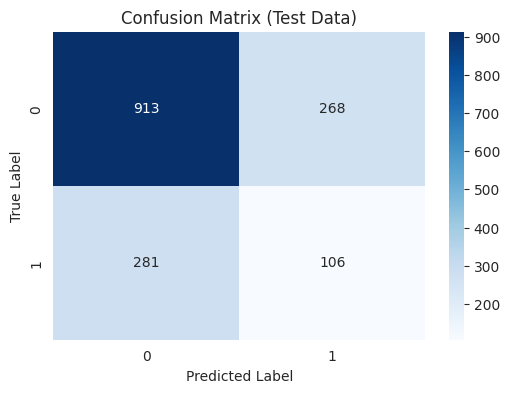

In [ ]:
# 5. Confusion Matrix for Test Set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### **Applying L1 L2 regularization on XGB**

In [ ]:
# --- Define a Hyperparameter Grid Including L1 & L2 Regularization ---
from scipy.stats import randint, uniform

param_dist_l1_l2 = {
    # Previous regularization parameters
    'max_depth': randint(3, 7),
    'min_child_weight': randint(3, 20),
    'gamma': uniform(0, 5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'learning_rate': uniform(0.01, 0.15),
    'n_estimators': randint(200, 1200),

    # --- ADD L1 and L2 REGULARIZATION PARAMETERS ---
    'reg_alpha': uniform(0, 5),  # L1 regularization. Range from 0 to 5.
    'reg_lambda': uniform(1, 10)  # L2 regularization. Start with 1 (default) and go up.
}

# --- Set up the Randomized Search as before ---
# (The rest of your RandomizedSearchCV setup code remains the same)

xgb_l1_l2 = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

random_search_l1_l2 = RandomizedSearchCV(
    estimator=xgb_l1_l2,
    param_distributions=param_dist_l1_l2,
    n_iter=150,  # You might want to increase n_iter to explore these new parameters
    scoring='recall',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print("--- Starting Tuning with L1 & L2 Regularization... ---")

--- Starting Tuning with L1 & L2 Regularization... ---


In [ ]:
# 1. Fit best_model on the full training set
random_search_l1_l2.fit(X_train_final, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cacb5d47190>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cacb5886e50>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cacb5c1dc90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cacb540bcd0>},
                   random_state=42, return_train_score=True, scoring='recall',
                   verbose=2)

In [ ]:
random_search_l1_l2.best_params_

{'colsample_bytree': np.float64(0.9913174735496102),
 'gamma': np.float64(4.721332445567169),
 'learning_rate': np.float64(0.08113213249861956),
 'max_depth': 4,
 'min_child_weight': 9,
 'n_estimators': 1194,
 'reg_alpha': np.float64(1.5955023662162782),
 'reg_lambda': np.float64(9.289154741506774),
 'subsample': np.float64(0.7111022904146478)}

In [ ]:
# 2. Predict on both train and test
y_train_pred_l1l2 = random_search_l1_l2.predict(X_train_final)
y_test_pred_l1l2 = random_search_l1_l2.predict(X_test_final)

# predict_proba for ROC AUC
y_train_proba_l1l2 = best_model.predict_proba(X_train_final)[:, 1]
y_test_proba_l1l2 = best_model.predict_proba(X_test_final)[:, 1]

In [ ]:
# 3. Define a function to print metrics
def print_metrics(y_true, y_pred, y_proba, dataset_name="Data"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_true, y_proba, multi_class='ovr'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [ ]:
# 4. Print metrics
print_metrics(y_train, y_train_pred_l1l2, y_train_proba_l1l2, "Train")
print_metrics(y_test, y_test_pred_l1l2, y_test_proba_l1l2, "Test")


--- Train Metrics ---
Accuracy: 0.5779114270092947
Precision: 0.5495466661817366
Recall: 0.5648516310645488
F1 Score: 0.5340773200638834
ROC AUC: 0.6190912563864237

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.59      0.68      2737
           1       0.31      0.54      0.39       921

    accuracy                           0.58      3658
   macro avg       0.55      0.56      0.53      3658
weighted avg       0.67      0.58      0.61      3658


--- Test Metrics ---
Accuracy: 0.5369897959183674
Precision: 0.5122411195823415
Recall: 0.5163035749058631
F1 Score: 0.490423232769966
ROC AUC: 0.516130726161642

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.56      0.64      1181
           1       0.26      0.48      0.34       387

    accuracy                           0.54      1568
   macro avg       0.51      0.52      0.49      1568
weighted avg       0.6

In [ ]:
# import joblib
# joblib.dump(random_search_l1_l2, 'random_search_l1_l2.pkl')

# from google.colab import files
# files.download('random_search_l1_l2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>